In [1]:
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import os
import joblib
from sklearn.compose import ColumnTransformer

In [2]:
game_data = pd.read_csv("../Data/data/clean_game_data.csv",dtype={"p1_id" : "string","p2_id" : "string","p1_char" : "string", "p2_char" : "string", "stage" : "string", "p1_games_played" : "int32", "p1_games_won" : "int32", "p2_games_played" : "int32", "p2_games_won" : "int32", "p1_won" : "bool"})
game_data = pd.get_dummies(game_data, columns=["p1_char","p2_char","stage"], prefix_sep=".", )
game_data

,p1_id,p2_id,p1_won,p1_games_played,p1_games_won,p2_games_played,p2_games_won,p1_char.-1,p1_char.banjokazooie,p1_char.bayonetta,...,stage.Town and City,stage.Unova Pokemon League,stage.Unova Pokémon League,stage.Venom,stage.WarioWare,stage.Wily Castle,stage.Yggdrasil's Altar,stage.Yoshi's Island,stage.Yoshi's Island (Melee),stage.Yoshi's Story
0,1472816,1075251,False,2,0,23,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1075251,1472816,True,23,13,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,challonge__MrRiceman,challonge__Loconotcoco,False,4,1,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Leo,1272809,True,1,1,102,49,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1034645,1302612,True,77,40,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2963854,30896,4702,False,72,51,865,555,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2963855,4702,30896,True,865,555,72,51,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2963856,1263104,53481,True,186,112,8,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2963857,53481,1263104,False,8,7,186,112,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In `sklearn`, there aren't recipes. Instead, there are pipelines, which works a bit like a recipe and a workflow combined. We can apply transformations to our data including selecting predictors, normalizing variables, and adding models.

In [3]:
game_train, game_test = train_test_split(game_data, train_size = 0.8, stratify = game_data[["p1_won"]], random_state=2049)

# We stratified on our response, p1_won. 
# This shouldn't make too much of a difference because we randomized which is p1 and p2, however it is still good practice.

X = game_train.loc[:,game_train.columns != "p1_won"]
y = game_train["p1_won"]

game_folded = StratifiedKFold(n_splits=5).split(X,y)

Let's start by using our numerical predictors to fit a linear model. We want to use a logistic regression because we are predicting a binary class. We're going to score by accuracy because there is no class imbalance present (because we randomized p1_won) and accuracy is much easier to interpret.

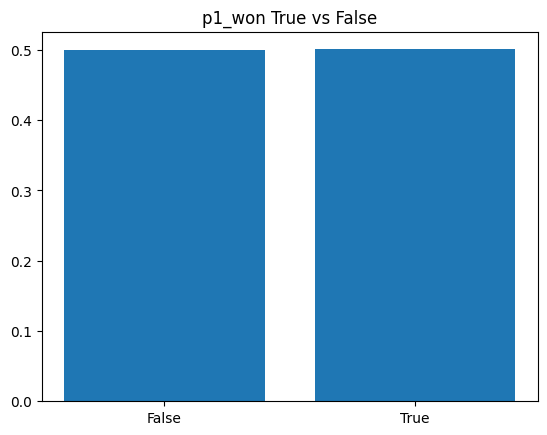

In [4]:
plt.bar(x = [True, False], height = game_train["p1_won"].value_counts() / len(game_train))
plt.xticks([True, False], ["True", "False"])
plt.title("p1_won True vs False")
plt.show()

In [5]:
def fitmodel(model, filename, df = game_train):
    
    if not os.path.isfile(filename):

        model.fit(X,y)

        joblib.dump(model, filename)

    else:
        modeltemp = joblib.load(filename)
        if (type(model) != type(modeltemp)) or \
            (tuple([k[0] for k in model.steps]) != tuple([k[0] for k in modeltemp.steps])):
            print ("\033[93m Warning: model mismatch. Delete the file {filename} and rerun or risk faulty models.\n \033[0m".format(filename=filename))
        model = modeltemp
    return model


First let's fit a logistic regression with no penalty. For this and the elastic net, we'll just use the numerical predictors.

In [25]:
lm_predictors = ["p1_games_played","p2_games_played","p1_games_won","p2_games_won"]

lm_pipe = Pipeline(steps = [
    ("predictors", ColumnTransformer([("predictors","passthrough",lm_predictors)])),
    ("logistic", linear_model.LogisticRegression(penalty=None))
    ])

game_folded = StratifiedKFold(n_splits=5).split(X,y)

lm_cross_val = cross_val_score(estimator = lm_pipe,
                               cv = game_folded,
                               scoring = 'accuracy'
                               X = X,
                               y = y)

print("%0.4f accuracy with a standard deviation of %0.4f." % (lm_cross_val.mean(), lm_cross_val.std()))

0.6433 accuracy with a standard deviation of 0.0007.


In [28]:
lm = fitmodel(model = lm_pipe,
              filename = "models/logistic_regression.joblib")

Now we're going to use an elastic net and tune the parameter `l1_ratio`, which gives the proportion of lasso regression to ridge regression. A value of `1.0` is expressed as a lasso regression, `0.0` is expressed as a ridge regression, and anything in between is some sort of elastic net. 

We can also tune C, a hyperparameter which controls penalty strength.

In [73]:
en_predictors = ["p1_games_played","p2_games_played","p1_games_won","p2_games_won"]

en_pipe = Pipeline(steps = [
    ("predictors", ColumnTransformer([("predictors","passthrough",en_predictors)])),
    ("logistic", linear_model.LogisticRegression(solver='saga',penalty='elasticnet'))
    ])

en_grid = dict(logistic__l1_ratio = [0.0, 0.10, 0.25, 0.50, 0.75, 0.90, 1.0],
               logistic__C = [1000, 100, 10, 1.0, 0.1, 0.01, 0.001])

game_folded = StratifiedKFold(n_splits=5).split(X,y)

en_grid_search = GridSearchCV(estimator = en_pipe,
                            param_grid = en_grid,
                            n_jobs = 1,
                            cv = game_folded,
                            scoring = 'accuracy',
                            error_score = 0,
                            verbose = 4)

In [74]:
en_grid_result = en_grid_search.fit(X[en_predictors],y) # We pass in X[en_predictors] because the result is the same but slightly faster.

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV 1/5] END logistic__C=1000, logistic__l1_ratio=0.0;, score=0.679 total time=   7.2s
[CV 2/5] END logistic__C=1000, logistic__l1_ratio=0.0;, score=0.679 total time=   7.2s
[CV 3/5] END logistic__C=1000, logistic__l1_ratio=0.0;, score=0.679 total time=   7.1s
[CV 4/5] END logistic__C=1000, logistic__l1_ratio=0.0;, score=0.681 total time=   7.7s
[CV 5/5] END logistic__C=1000, logistic__l1_ratio=0.0;, score=0.680 total time=   7.0s
[CV 1/5] END logistic__C=1000, logistic__l1_ratio=0.1;, score=0.679 total time=   7.2s
[CV 2/5] END logistic__C=1000, logistic__l1_ratio=0.1;, score=0.679 total time=   7.3s
[CV 3/5] END logistic__C=1000, logistic__l1_ratio=0.1;, score=0.679 total time=   7.2s
[CV 4/5] END logistic__C=1000, logistic__l1_ratio=0.1;, score=0.681 total time=   7.3s
[CV 5/5] END logistic__C=1000, logistic__l1_ratio=0.1;, score=0.680 total time=   7.3s


KeyboardInterrupt: 

In [100]:
print("C = {bestC}, l1_ratio = {bestratio}, with an accuracy of {bestScore}.\n".format(
    bestC = en_grid_result.best_params_['logistic__C'],
    bestratio = en_grid_result.best_params_['logistic__l1_ratio'],
    bestScore = en_grid_result.best_score_))

res = pd.DataFrame(en_grid_result.cv_results_)
print(res[['param_logistic__l1_ratio','param_logistic__C','mean_test_score']])

C = 0.01, l1_ratio = 1.0, with an accuracy of 0.6431155838173498.

   param_logistic__l1_ratio param_logistic__C  mean_test_score
0                       0.0              1000         0.643111
1                       0.1              1000         0.643091
2                      0.25              1000         0.643102
3                       0.5              1000         0.643092
4                      0.75              1000         0.643100
5                       0.9              1000         0.643089
6                       1.0              1000         0.643097
7                       0.0               100         0.643077
8                       0.1               100         0.643110
9                      0.25               100         0.643108
10                      0.5               100         0.643092
11                     0.75               100         0.643105
12                      0.9               100         0.643094
13                      1.0               100      

In [60]:
en_pipe.set_params(logistic__C = 0.01, logistic__l1_ratio = 1.0)
en = fitmodel(model = en_pipe,
              filename = "models/elastic_net.joblib")

One thing to keep in mind is that games played and games won are relative to the size of the dataset, so it might be a good idea to use a proportion between players instead in case someone wants to use the final model on a dataset which is not of the same size. It's unclear if this will matter though.

The goal of this project is more interpretation/inference than predicition, so we can hold this thought for now.

In [120]:
dtc_predictors = list(set(game_train.head()).difference({"p1_won","p1_id","p2_id"}))

dtc_pipe = Pipeline(steps = [
    ("predictors", ColumnTransformer([("predictors","passthrough",dtc_predictors)])),
    ("decision_tree", tree.DecisionTreeClassifier(random_state = 42))
    ])

dtc_grid = dict(decision_tree__ccp_alpha = [0.000, 0.005, 0.010, 0.020],
                decision_tree__max_depth = [3, 5, 10, None],
                decision_tree__min_samples_leaf = [1, 3, 5, 10])

game_folded = StratifiedKFold(n_splits=5).split(X,y)

dtc_grid_search = GridSearchCV(estimator = dtc_pipe,
                               param_grid = dtc_grid,
                               n_jobs = 4,
                               cv = game_folded,
                               scoring = 'accuracy',
                               error_score = 0,
                               verbose = 10)

In [121]:
dtc_grid_result = dtc_grid_search.fit(X[dtc_predictors],y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


KeyboardInterrupt: 

In [ ]:
print("Max Features = {bestccp}, Max Depth = {bestMD}, Min Samples Leaf = {bestMS}, with an accuracy of {bestScore}.\n".format(
    bestccp = dtc_grid_result.best_params_['decision_tree__ccp_alpha'],
    bestMD = dtc_grid_result.best_params_['decision_tree__max_depth'],
    bestMS = dtc_grid_result.best_params_['decision_tree__min_samples_leaf'],
    bestScore = dtc_grid_result.best_score_))

res = pd.DataFrame(dtc_grid_result.cv_results_)
print(res[['param_decision_tree__max_features',
           'param_decision_tree__max_depth',
           'param_decision_tree__min_samples_leaf',
           'mean_test_score']])

Max Features = None, Max Depth = 10, Min Samples Leaf = 10, with an accuracy of 0.646869980057419.

   param_decision_tree__max_features param_decision_tree__max_depth  \
0                               sqrt                              3   
1                               sqrt                              3   
2                               sqrt                              3   
3                               sqrt                              3   
4                               log2                              3   
5                               log2                              3   
6                               log2                              3   
7                               log2                              3   
8                               None                              3   
9                               None                              3   
10                              None                              3   
11                              None            

In [119]:
dtc_pipe.set_params(decision_tree__max_features = None, decision_tree__max_depth = 10, decision_tree__min_samples_leaf = 10)

dtc = fitmodel(model = dtc_pipe,
               filename = "models/decision_tree.joblib")

In [6]:
rfc_predictors = list(set(game_train.head()).difference({"p1_won","p1_id","p2_id"}))

rfc_pipe = Pipeline(steps = [
            ("predictors", ColumnTransformer([("predictors","passthrough",rfc_predictors)])),
            ("random_forest", ensemble.RandomForestClassifier(verbose = 3, n_jobs = 4, random_state = 420))
            ])

rfc_grid = dict(random_forest__n_estimators = [50,100,150,200],
                random_forest__max_features = ["sqrt","log2"],
                random_forest__min_samples_leaf = [1, 3, 5, 10])

game_folded = StratifiedKFold(n_splits=5).split(X,y)

rfc_grid_search = GridSearchCV(estimator = rfc_pipe,
                               param_grid = rfc_grid,
                               n_jobs = 1,
                               cv = game_folded,
                               scoring = 'accuracy',
                               error_score = 0,
                               verbose = 10)

In [7]:
rfc_grid_results = rfc_grid_search.fit(X,y)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5; 1/32] START random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__n_estimators=50


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  4.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.8s finished


[CV 1/5; 1/32] END random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__n_estimators=50;, score=0.663 total time= 4.1min
[CV 2/5; 1/32] START random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__n_estimators=50


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  4.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.8s finished


[CV 2/5; 1/32] END random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__n_estimators=50;, score=0.665 total time= 4.1min
[CV 3/5; 1/32] START random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__n_estimators=50


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  4.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.8s finished


[CV 3/5; 1/32] END random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__n_estimators=50;, score=0.664 total time= 4.1min
[CV 4/5; 1/32] START random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__n_estimators=50


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:
print("Max Features = {bestn}, Max Depth = {bestMF}, Min Samples Leaf = {bestMS}, with an accuracy of {bestScore}.\n".format(
    bestn = dtc_grid_result.best_params_['random_forest__n_estimators'],
    bestMF = dtc_grid_result.best_params_['random_forest__max_features'],
    bestMS = dtc_grid_result.best_params_['random_forest__min_samples_leaf'],
    bestScore = dtc_grid_result.best_score_))

res = pd.DataFrame(dtc_grid_result.cv_results_)
print(res[['param_random_forest__n_estimators',
           'param_random_forest__max_features',
           'param_random_forest__min_samples_leaf',
           'mean_test_score']])

In [ ]:
gbc = None
gbcfile = "models/boosted_tree.joblib"

predictors = list(set(game_train.head()).difference({"p1_won","p1_id","p2_id"}))
response = "p1_won"

if not os.path.isfile(gbcfile):
    gbc = ensemble.GradientBoostingClassifier(verbose=3,n_estimators=1000)

    x = game_train[predictors]
    y = game_train[response]

    gbc.fit(x,y)

    joblib.dump(gbc,gbcfile)
else:
    gbc = joblib.load(gbcfile)

prediction = gbc.predict(game_train[gbc.feature_names_in_])
actual = game_train[response]

print("Accuracy: {acc}".format(acc = accuracy_score(prediction,actual)))

      Iter       Train Loss   Remaining Time 
         1           1.3699          173.08m
         2           1.3559          167.11m
         3           1.3441          163.77m
         4           1.3339          162.37m
         5           1.3253          161.80m
         6           1.3177          160.94m
         7           1.3114          160.17m
         8           1.3059          159.88m
         9           1.3011          159.59m
        10           1.2968          159.46m
        11           1.2930          159.16m
        12           1.2897          159.60m
        13           1.2869          159.73m
        14           1.2842          159.98m
        15           1.2820          159.91m
        16           1.2798          159.95m
        17           1.2780          159.86m
        18           1.2761          159.32m
        19           1.2746          158.91m
        20           1.2732          158.32m
        21           1.2719          158.10m
        2

In [ ]:
prediction = gbc.predict(game_test[gbc.feature_names_in_])
actual = game_test[response]

print("Accuracy: {acc}".format(acc = accuracy_score(prediction,actual)))
# CROSS VALIDATION FIRST

Accuracy: 0.6854507297915556
